In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname="C:\\Windows\\Fonts\\malgun.ttf").get_name()
plt.rc("font", family = font_name)

import matplotlib as mlp
mlp.rcParams["axes.unicode_minus"] = False

In [2]:
# import urllib.request as req
# from urllib.error import HTTPError, URLError
# import requests
# from bs4 import BeautifulSoup

In [3]:
# from selenium import webdriver
# from selenium.webdriver.common.by import By
# from selenium.webdriver.common.keys import Keys

# from webdriver_manager.chrome import ChromeDriverManager
# from selenium.webdriver.chrome.service import Service

# import time

In [4]:
import folium
import json

In [5]:
# from glob import glob

# 지점별 교통량

## (1) 교통량

### 1) 데이터 로드

- 지점별일자별 교통량(TOPIS) : 2023.02 기준
- https://topis.seoul.go.kr/refRoom/openRefRoom_2.do

In [6]:
traffic = pd.read_excel("../../Data/차,주차장/02월 서울시 교통량 조사자료(2023)_인코딩.xlsx", 
                        sheet_name="2023년 02월")
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7784 entries, 0 to 7783
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   일자      7784 non-null   int64  
 1   요일      7784 non-null   object 
 2   지점명     7784 non-null   object 
 3   지점번호    7784 non-null   object 
 4   방향      7784 non-null   object 
 5   구분      7784 non-null   object 
 6   0시      6101 non-null   float64
 7   1시      6100 non-null   float64
 8   2시      6099 non-null   float64
 9   3시      6091 non-null   float64
 10  4시      6091 non-null   float64
 11  5시      6091 non-null   float64
 12  6시      6092 non-null   float64
 13  7시      6095 non-null   float64
 14  8시      6096 non-null   float64
 15  9시      6097 non-null   float64
 16  10시     6099 non-null   float64
 17  11시     6105 non-null   float64
 18  12시     6105 non-null   float64
 19  13시     6102 non-null   float64
 20  14시     6107 non-null   float64
 21  15시     6108 non-null   float64
 22  

### 2) 결측치 0으로 변경

In [7]:
traffic=traffic.fillna(0)

### 3) 교통량 평균

In [8]:
# 일별 시간 평균

hour = [(str(i)+"시") for i in range(0,24)]
traffic["시간대별평균"]=traffic[hour].mean(axis=1)

In [9]:
# traffic["시간대별평균"]

In [10]:
## 일별 평균

df = traffic.groupby(["지점번호","방향"])[["시간대별평균"]].mean()
df.reset_index(["지점번호","방향"])

,지점번호,방향,시간대별평균
0,A-01,유입,1280.438988
1,A-01,유출,1157.793155
2,A-02,유입,0.000000
3,A-02,유출,0.000000
4,A-03,유입,552.065476
...,...,...,...
273,F-08,유출,1972.846726
274,F-09,유입,893.744048
275,F-09,유출,1091.482143
276,F-10,유입,1059.016369


In [11]:
# 지점별 평균
df1=df.groupby("지점번호")["시간대별평균"].mean()
df1

지점번호
A-01    1219.116071
A-02       0.000000
A-03     522.048363
A-04     107.153274
A-05     777.905506
           ...     
F-06    3908.540923
F-07    2719.965774
F-08    1966.406994
F-09     992.613095
F-10    1114.029762
Name: 시간대별평균, Length: 139, dtype: float64

## (2) 수집 지점 위치 정보

### 1) 데이터 로드

In [12]:
addr = pd.read_excel("../../Data/차,주차장/02월 서울시 교통량 조사자료(2023)_인코딩.xlsx", 
                        sheet_name="수집지점 주소 및 좌표")
addr.info()
addr.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   지점번호    141 non-null    object 
 1   지점명칭    139 non-null    object 
 2   검지기 유형  139 non-null    object 
 3   위도      139 non-null    float64
 4   경도      139 non-null    float64
 5   주소      139 non-null    object 
 6   도로명 주소  33 non-null     object 
 7   유입 방향   139 non-null    object 
 8   유출방향    139 non-null    object 
dtypes: float64(2), object(7)
memory usage: 10.2+ KB


,지점번호,지점명칭,검지기 유형,위도,경도,주소,도로명 주소,유입 방향,유출방향
0,A-01,성산로(금화터널),지자기,37.568588,126.948436,서울시 서대문구 신촌동 1-142,NaN,[성산로]봉원고가차도->독립문역,[성산로]독립문역->봉원고가차도
1,A-02,사직로(사직터널),지자기,37.572298,126.962853,서울시 종로구 행촌동 1-186,NaN,[사직로]독립문역->사직단,[사직로]사직단->독립문역
2,A-03,자하문로(자하문터널),지자기,37.588831,126.968548,서울시 종로구 청운동 24-6,NaN,[자하문로]석파정->청운초등학교,[자하문로]청운초등학교->석파정
3,A-04,대사관로(삼청터널),지자기,37.596359,126.984209,서울시 성북구 성북동 산25-148,NaN,[삼청로]삼청각->삼청공원입구,[삼청로]삼청공원입구->삼청각
4,A-05,율곡로(안국역),지자기,37.576000,126.984342,서울시 종로구 경운동 90-4,서울시 종로구 율곡로 46,[율곡로]안국역->안국동사거리,[율곡로]안국동사거리->안국역


### 2) 지점별 위치 시각화

In [13]:
map = folium.Map(location=[37.5000195, 127.0229206],zoom_start=11)

for i in range(len(addr["지점번호"])) :
#     print(addr.loc[i, "위도"] ,addr.loc[i, "경도"])
    if addr.loc[i, "위도"] > 0 :
        folium.Marker(location=[addr.loc[i, "위도"] ,addr.loc[i, "경도"]], 
                      icon=folium.Icon(color="red", icon="star"),
                      popup=addr.loc[i, "지점명칭"]).add_to(map)
map

## (3) 데이터 프레임 병합

- 지점별 교통량과 위치 정보 데이터프레임 병합
- 평균이 0인 지점 제외

### 1) 병합

In [14]:
m=pd.merge(df1, 
           addr[["지점번호","지점명칭","주소","위도","경도"]],
           on="지점번호")
m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139 entries, 0 to 138
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   지점번호    139 non-null    object 
 1   시간대별평균  139 non-null    float64
 2   지점명칭    139 non-null    object 
 3   주소      139 non-null    object 
 4   위도      139 non-null    float64
 5   경도      139 non-null    float64
dtypes: float64(3), object(3)
memory usage: 7.6+ KB


### 2) 시군구 구하기

In [15]:
s = m["주소"].str.split(" ")
spot_gu =[]
spot_sido=[]
for i in s :
    spot_sido.append(i[0])
    spot_gu.append(i[1])

In [16]:
m["시도"] = spot_sido
m["시군구"] = spot_gu

In [17]:
m

,지점번호,시간대별평균,지점명칭,주소,위도,경도,시도,시군구
0,A-01,1219.116071,성산로(금화터널),서울시 서대문구 신촌동 1-142,37.568588,126.948436,서울시,서대문구
1,A-02,0.000000,사직로(사직터널),서울시 종로구 행촌동 1-186,37.572298,126.962853,서울시,종로구
2,A-03,522.048363,자하문로(자하문터널),서울시 종로구 청운동 24-6,37.588831,126.968548,서울시,종로구
3,A-04,107.153274,대사관로(삼청터널),서울시 성북구 성북동 산25-148,37.596359,126.984209,서울시,성북구
4,A-05,777.905506,율곡로(안국역),서울시 종로구 경운동 90-4,37.576000,126.984342,서울시,종로구
...,...,...,...,...,...,...,...,...
134,F-06,3908.540923,경부고속도로,서울시 서초구 서초동 1748-26,37.493135,127.022533,서울시,서초구
135,F-07,2719.965774,분당수서로,서울시 강남구 일원동 467-1,37.497648,127.087195,서울시,강남구
136,F-08,1966.406994,강남순환로(관악터널),서울시 금천구 시흥동 산 93-1,37.449096,126.926169,서울시,금천구
137,F-09,992.613095,서부간선지하도로,서울시 금천구 가산동 338-10,37.468942,126.883673,서울시,금천구


### 3) 불필요한 값 제외

- 서울시 지점 추출
- 평균이 0인 값 삭제 : 결측치를 0으로 변경하였기 때문에 제거

In [18]:
m2=m[(m["시도"]=="서울시") & (m["시간대별평균"] > 0)]
m2

,지점번호,시간대별평균,지점명칭,주소,위도,경도,시도,시군구
0,A-01,1219.116071,성산로(금화터널),서울시 서대문구 신촌동 1-142,37.568588,126.948436,서울시,서대문구
2,A-03,522.048363,자하문로(자하문터널),서울시 종로구 청운동 24-6,37.588831,126.968548,서울시,종로구
3,A-04,107.153274,대사관로(삼청터널),서울시 성북구 성북동 산25-148,37.596359,126.984209,서울시,성북구
4,A-05,777.905506,율곡로(안국역),서울시 종로구 경운동 90-4,37.576000,126.984342,서울시,종로구
5,A-06,841.890625,창경궁로(서울여자대학교),서울시 종로구 명륜4가 197-5,37.582526,126.998011,서울시,종로구
...,...,...,...,...,...,...,...,...
134,F-06,3908.540923,경부고속도로,서울시 서초구 서초동 1748-26,37.493135,127.022533,서울시,서초구
135,F-07,2719.965774,분당수서로,서울시 강남구 일원동 467-1,37.497648,127.087195,서울시,강남구
136,F-08,1966.406994,강남순환로(관악터널),서울시 금천구 시흥동 산 93-1,37.449096,126.926169,서울시,금천구
137,F-09,992.613095,서부간선지하도로,서울시 금천구 가산동 338-10,37.468942,126.883673,서울시,금천구


#### 가. 시각화 : 시군구별 평균교통량

<AxesSubplot:title={'center':'시간대별평균'}, xlabel='[시군구]'>

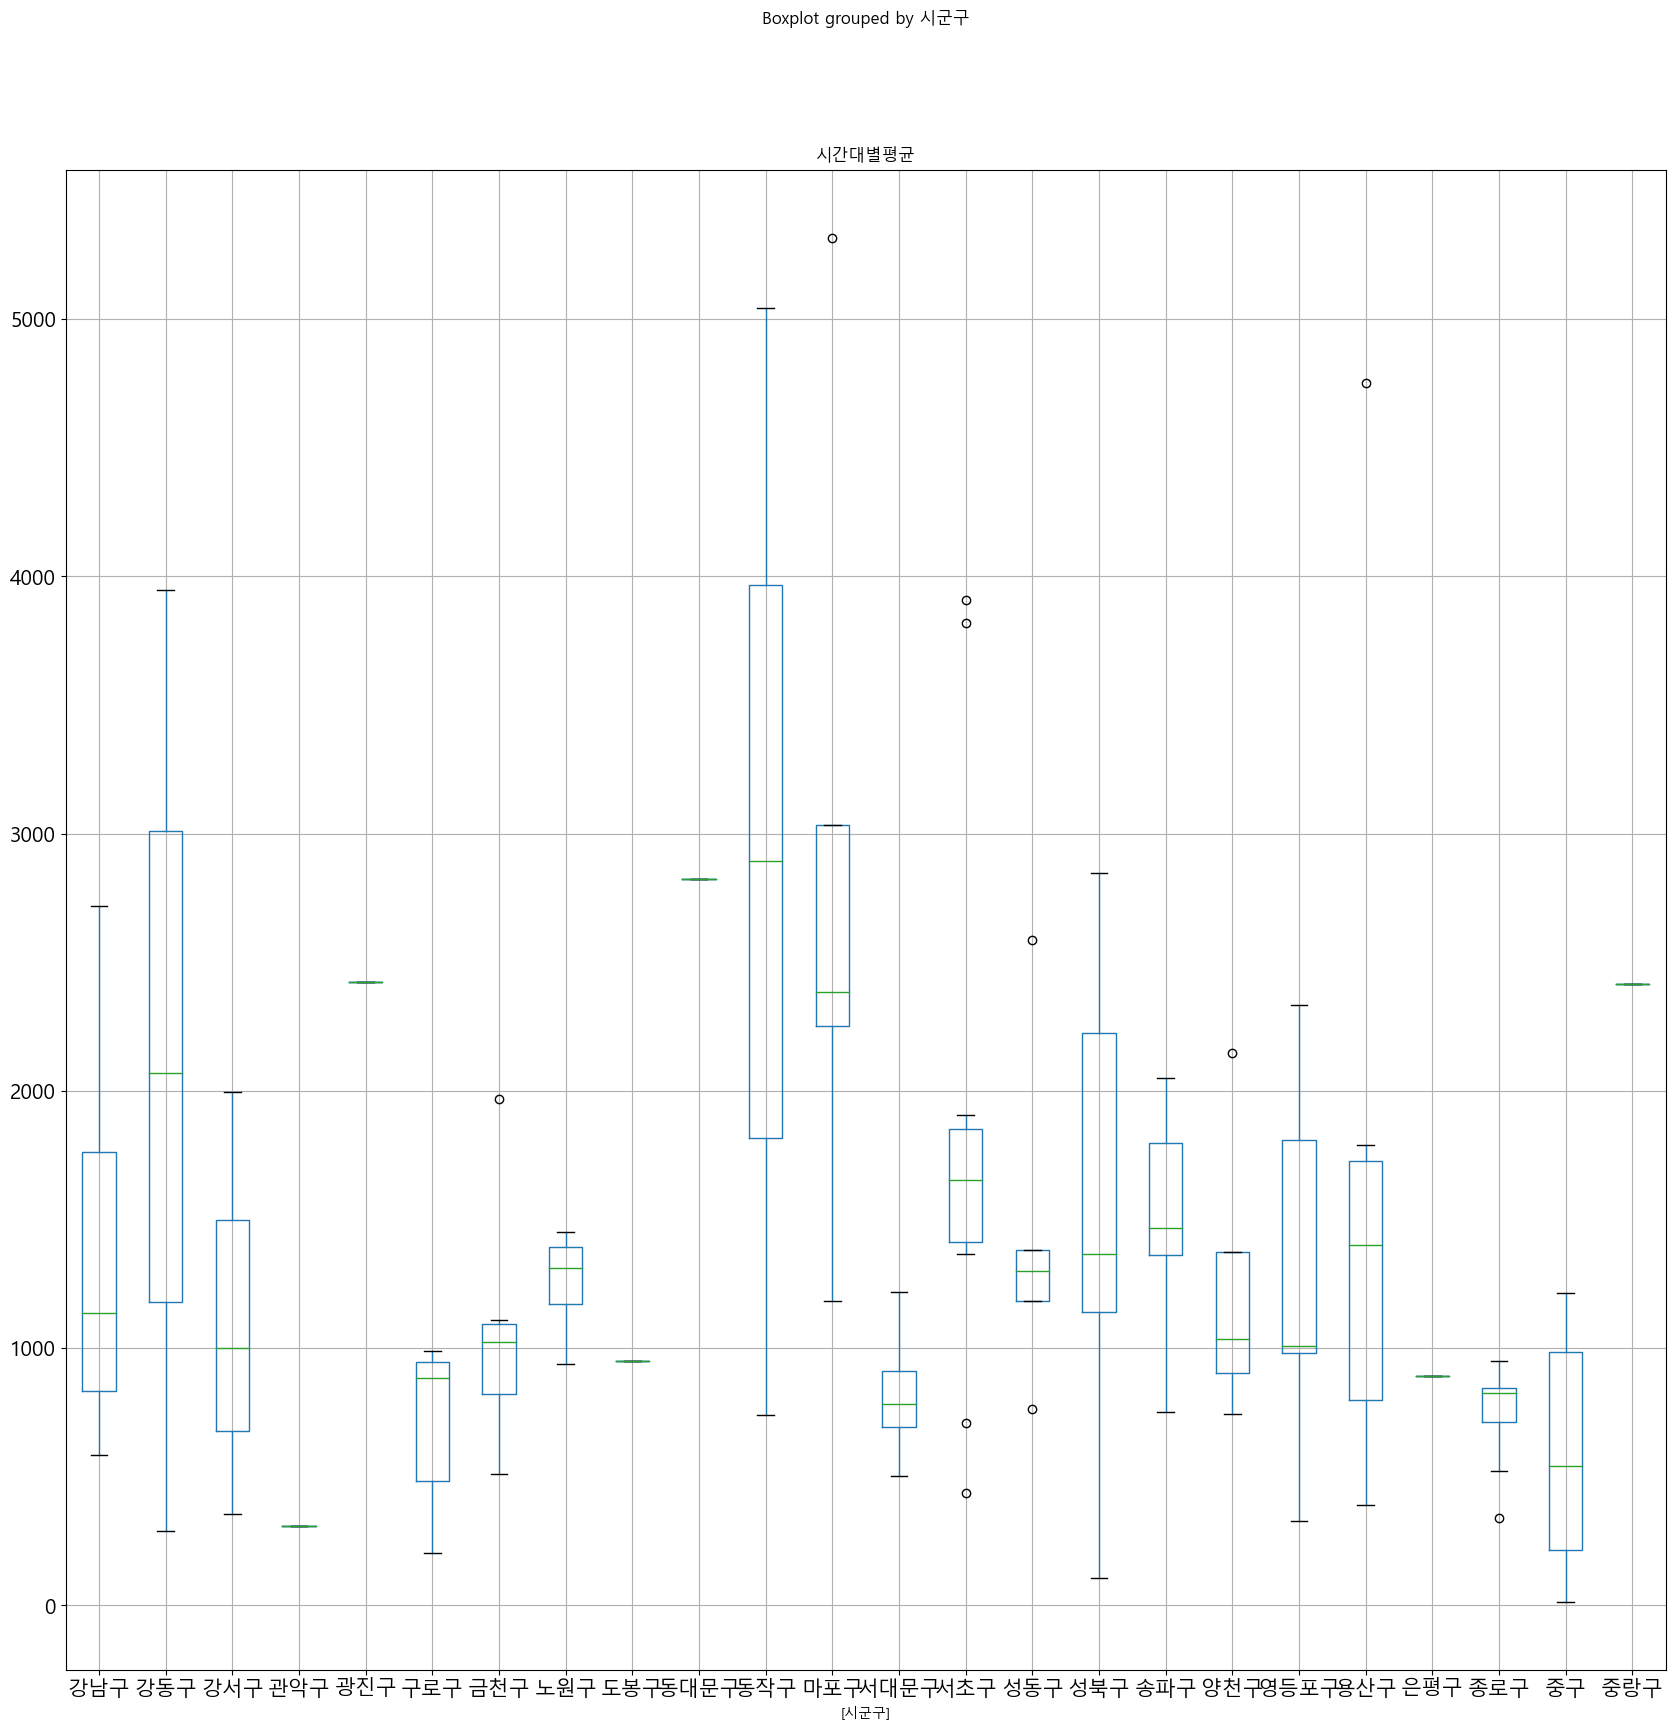

In [19]:
m2[["시간대별평균","시군구"]].boxplot(by="시군구",figsize=(20,20),fontsize=15)

### 4) 구별 교통량 평균

- 결과 : 광진구는 평균 교통량이 타 자치구에 비해 많은편
        그러나 수집지점이 한곳뿐

In [20]:
traffic_gu=m2.groupby("시군구")[["시간대별평균"]].mean()
# traffic_gu.sort_values(by="시간대별평균",ascending=False)

In [21]:
traffic_gu.sort_values(by="시간대별평균", ascending=False)

,시간대별평균
시군구,
동작구,2891.614583
마포구,2833.697619
동대문구,2821.638393
광진구,2423.412202
중랑구,2414.037202
강동구,2101.661210
서초구,1869.332664
용산구,1655.397747
성북구,1537.672321


#### 가. 구별 교통량 수집 지점 개수

In [22]:
m2.groupby("시군구")[["시간대별평균"]].count()

,시간대별평균
시군구,
강남구,10
강동구,3
강서구,3
관악구,1
광진구,1
구로구,5
금천구,6
노원구,4
도봉구,1


In [23]:
traffic_gu.reset_index(inplace=True)

#### ※ 구별교통량 평균 check point

In [24]:
traffic_gu.to_csv("../../Data/차,주차장/구별교통량평균.csv", encoding="utf-8")

### 5) 시각화

In [25]:
import json
geo=json.load(open("../../Data/기타/skorea_municipalities_geo_simple_seoul.json",
                  encoding="utf-8"))
import folium

map = folium.Map(location=[37.5000195, 127.0229206],zoom_start=11)

map.choropleth(geo_data=geo, data=traffic_gu, key_on="feature.id",
               columns=["시군구", "시간대별평균"],
               fill_color="PuRd")

for i in m2.index :
    if m2["시군구"][i]=="광진구" :
        folium.Marker(location=[m2.loc[i, "위도"], m2.loc[i, "경도"]], 
                        icon=folium.Icon(color="blue", icon="star"),
                        popup=m2.loc[i, "지점명칭"]).add_to(map)
    else :
        folium.Marker(location=[m2.loc[i, "위도"], m2.loc[i, "경도"]], 
                        icon=folium.Icon(color="red", icon="star"),
                        popup=m2.loc[i, "지점명칭"]).add_to(map)

map

C:\Users\acorn\anaconda3\lib\site-packages\folium\folium.py:465: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


<AxesSubplot:ylabel='시군구'>

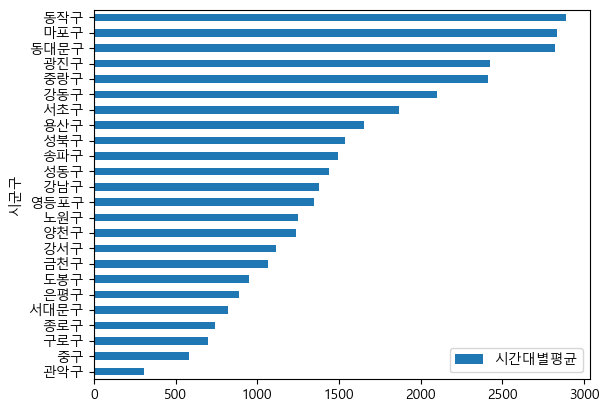

In [26]:
traffic_gu2=traffic_gu.set_index("시군구")
traffic_gu2.sort_values(by="시간대별평균").plot.barh()

# 2. 교통량 대비 주차면수

## (1) 주차장면수 데이터 로드

In [27]:
park=pd.read_csv("../../Data/차,주차장/구별 차량대비 주차면수.csv", 
                 usecols=["시군구","합계면수"])

In [28]:
res = pd.merge(traffic_gu, park,on="시군구")

In [29]:
res=res.rename(columns={"시간대별평균":"교통량평균"})

In [30]:
# del res["정규화"]

## (2) 교통량 대비 주차면수(구별)

- 결과 : 다른 구대비 광진구의 교통량대비주차면수가 낮은 편

In [31]:
res["교통량대비주차면수"]=res["합계면수"]/res["교통량평균"]

In [32]:
res.sort_values(by="교통량대비주차면수",ascending=False)

,시군구,교통량평균,합계면수,교통량대비주차면수
3,관악구,308.089286,153960,499.725265
0,강남구,1379.695387,413898,299.992305
2,강서구,1117.483631,315812,282.609956
5,구로구,700.373214,191823,273.886831
16,송파구,1494.971974,339227,226.911946
20,은평구,890.304315,176603,198.362511
22,중구,580.353152,109153,188.080309
13,서초구,1869.332664,310949,166.342249
12,서대문구,821.323661,132942,161.863108
18,영등포구,1345.250083,203359,151.168175


### 1) 시각화

In [33]:
res1=res[["시군구", "교통량대비주차면수"]]
res1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   시군구        24 non-null     object 
 1   교통량대비주차면수  24 non-null     float64
dtypes: float64(1), object(1)
memory usage: 576.0+ bytes


In [34]:
import json
geo=json.load(open("../../Data/기타/skorea_municipalities_geo_simple_seoul.json",
                  encoding="utf-8"))
import folium

map = folium.Map(location=[37.5000195, 127.0229206],zoom_start=11)

map.choropleth(geo_data=geo, data=res1, key_on="feature.id",
               columns=["시군구", "교통량대비주차면수"],
               fill_color="PuRd")

for i in m2.index :
    if m2["시군구"][i]=="광진구" :
        folium.Marker(location=[m2.loc[i, "위도"], m2.loc[i, "경도"]], 
                        icon=folium.Icon(color="blue", icon="star"),
                        popup=m2.loc[i, "지점명칭"]).add_to(map)
    else :
        folium.Marker(location=[m2.loc[i, "위도"], m2.loc[i, "경도"]], 
                        icon=folium.Icon(color="red", icon="star"),
                        popup=m2.loc[i, "지점명칭"]).add_to(map)

map

C:\Users\acorn\anaconda3\lib\site-packages\folium\folium.py:465: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


---

## (3) 교통량 대비 주차면수(동별)

-  결과 : 광진구의 교통량 수집지점은 한곳뿐이라 비교 불가


### 1) 행정동 구하기

In [35]:
import requests

head = {"Authorization":"KakaoAK cbe1a3567ce9912ad46a4cf87043ad88"}

ka_dong = []

for a in m2["주소"]:
    url = "https://dapi.kakao.com/v2/local/search/address.json?query={}".format(a)
    try :
        place=requests.get(url,headers=head).json()['documents'][0]['address']['region_3depth_h_name']
        ka_dong.append(place)
    except :
        ka_dong.append(a.split(" ")[2])

In [36]:
m2["행정동"]=ka_dong
m2.head()

C:\Users\acorn\AppData\Local\Temp\ipykernel_16028\514464134.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m2["행정동"]=ka_dong


,지점번호,시간대별평균,지점명칭,주소,위도,경도,시도,시군구,행정동
0,A-01,1219.116071,성산로(금화터널),서울시 서대문구 신촌동 1-142,37.568588,126.948436,서울시,서대문구,신촌동
2,A-03,522.048363,자하문로(자하문터널),서울시 종로구 청운동 24-6,37.588831,126.968548,서울시,종로구,청운효자동
3,A-04,107.153274,대사관로(삼청터널),서울시 성북구 성북동 산25-148,37.596359,126.984209,서울시,성북구,성북동
4,A-05,777.905506,율곡로(안국역),서울시 종로구 경운동 90-4,37.576000,126.984342,서울시,종로구,종로1.2.3.4가동
5,A-06,841.890625,창경궁로(서울여자대학교),서울시 종로구 명륜4가 197-5,37.582526,126.998011,서울시,종로구,혜화동


In [37]:
gwangin=m2[m2["시군구"]=="광진구"]
gwangin
## 광진구는 지점이 자양동 뿐이라 행정동단위 분석 불가

,지점번호,시간대별평균,지점명칭,주소,위도,경도,시도,시군구,행정동
77,C-16,2423.412202,영동대교,서울시 광진구 자양동 825-1,37.530295,127.057339,서울시,광진구,자양동
